# Impact of Feature Selection on ROC-AUC and Training Time in Unsupervised Anomaly Detection Using SHAP Values
#### Writer: Hamidreza Salahi
#### Date: July 2024 (Week 4)

## 1. Overview

One of the key factors influencing the performance of anomaly detection models is the selection of relevant features. Effective feature selection can enhance model accuracy and reduce computational costs, thereby making it a critical step in the model development process.

This week, my focus shifted towards understanding the impact of feature selection on the performance and efficiency of the anomaly detection models. Specifically, I employed SHAP (SHapley Additive exPlanations) values to identify and rank the importance of features. By experimenting with different numbers of top features—namely 5, 10, 15, 20, 25, and the total number of features—I aimed to investigate how varying feature sets affect two key metrics: ROC-AUC and training time.

The ROC-AUC score is a valuable metric for evaluating the discriminative power of anomaly detection models, with higher values indicating better performance. Meanwhile, training time is a crucial factor for practical model deployment, as it reflects the computational efficiency of the model. By analyzing the relationship between the number of features, ROC-AUC scores, and training time, I seek to uncover insights that will guide effective feature selection strategies and optimize model performance.
### Dataset
 The dataset used in this notebook presents transactions that occurred in two days, where there are 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions. The dataset is sourced from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

### Assumption 
In this analysis, fraudulent transactions are treated as anomalies within the dataset.
### Goal

The goal of this notebook is to evaluate the impact of feature selection on the performance and efficiency of anomaly detection models. Specifically:

**Assess the Effect of Feature Quantity on Model Performance:**

Determining how varying the number of top features, as identified by SHAP values, influences the ROC-AUC score of anomaly detection models. The goal is to find an optimal number of features that maximizes ROC-AUC, thereby improving the model’s ability to distinguish between anomalies and normal data.

**Analyze the Impact on Training Time:**

Investigating how different feature sets affect the training time of the models. This involves identifying a balance between feature richness and computational efficiency, ensuring that the models are both accurate and practical for real-world applications.

**Identify the Optimal Feature Set:**

Finding the number of top features that provides the best trade-off between high ROC-AUC performance and acceptable training time. This will guide feature selection strategies and help streamline model development processes.

### Methodology
- $\textbf{Exploratory Data Analysis (EDA)}$: 
This initial phase aims to gain insights into the dataset's characteristics, including data quality checks such as handling null values and removing duplicates.


- $\textbf{Unsupervised Learning Techniques}$: 
Models such as Isolation Forest (IForest), K-Nearest Neighbors (KNN), Empirical Cumulative Distribution Functions (ECOD) and Local Outlier Factor (LOF) are applied to detect anomalies.

- $\textbf{Evaluation Metric}$:
The performance of the anomaly detection models is evaluated using AUC PR (Area Under the Precision-Recall Curve), chosen for its effectiveness in assessing model performance in the context of highly imbalanced datasets.

### Experiments 
In this week’s experiments, I utilized SHAP values to identify the most important features for the anomaly detection models. I selected various subsets of top important features—5, 10, 15, 20, 25, and all available features to assess their impact on model performance and efficiency. For each feature subset, I trained the models (LOF, KNN, ECOD and IForest) and evaluated their performance using the ROC-AUC metric while recording the training time. This approach allowed me to observe how changes in the number of features influence both the accuracy of anomaly detection and the computational resources required. By comparing these results, I aimed to identify the optimal number of features that balances high ROC-AUC scores with reasonable training times.

In [288]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score,confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve,
                             average_precision_score,auc)
from pyod.models.knn import KNN  
from pyod.models.lof import LOF 
from pyod.models.iforest import IForest 
from pyod.models.sod import SOD 
from pyod.models.ecod import ECOD 

import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import shap
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import time
import joblib
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from itertools import product


import warnings
warnings.filterwarnings("ignore")



## 2. Load datasets, EDA and Feature Engineering 

For this analysis, the **Credit Card Fraud Detection dataset** was selected from Kaggle. This dataset is a widely used benchmark for testing
anomaly detection algorithms due to its real-world nature and the challenge posed by its class
imbalance.

### 2.1 Load data

In [289]:
# Loading the dataset and Creating fraud dataframe

dataset_name = 'creditcard' 
df = pd.read_csv(dataset_name+'.csv')


### 2.2 EDA

In [290]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Observation: It seems that features V1-V28 are results of a PCA Dimensionality reduction to protect user identities and sensitive info.

### 2.2.1: Missing Values

In [291]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- no missing values

### 2.2.2: Check for standardization

In [292]:
description = df.describe()
description

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


- Observation: The data is not standardized. min and max are not always (0, 1) therefore no MinMaxScaler is used. Mean and std are not always (0,1) so no StandardScaler is used either. 

### 2.2.3: Check for duplicates and Dropping them

In [297]:
df.shape
duplicates = df[df.duplicated()]
print(f"There are {duplicates.shape[0]} duplicates in our dataframe which is {round(duplicates.shape[0]/df.shape[0],3)*100}% of the data")
df.drop_duplicates(inplace=True)

There are 1081 duplicates in our dataframe which is 0.4% of the data


### 2.2.4 Class imbalance

In [298]:
print(df['Class'].value_counts())

Class
0    283253
1       473
Name: count, dtype: int64


In [299]:
print(f"The {dataset_name} dataset has {round(df[df.Class==1].shape[0]/df.shape[0]*100,2) }% fraudulent transactions")

The creditcard dataset has 0.17% fraudulent transactions


## 2.3 Feature Selection

In [300]:
# Number of rows in the subsample
n_subsample = 30000

In [301]:
X = df.drop(columns=['Class'])
y = df['Class']
outliers = round(sum(y/len(y)*100),2)
print(f'The original {dataset_name} dataset has {len(y)} rows, {X.shape[1]} features and {outliers} % outliers')
data_combined = np.hstack((X, np.array(y).reshape(-1, 1)))  # Combine X and y to keep them together during sampling
subsampled_data = resample(data_combined, n_samples=n_subsample, stratify=y, random_state=42)  # Subsample the data while maintaining the class distribution
# Separate the subsample into features and target variable
X_subsample = subsampled_data[:, :-1]
y_subsample = subsampled_data[:, -1]
print(f'The subsample data has {X_subsample.shape[0]} rows, {X_subsample.shape[1]} features and {round(sum(y_subsample/len(y_subsample)*100),2)} % outliers')

The original creditcard dataset has 283726 rows, 30 features and 0.17 % outliers
The subsample data has 30000 rows, 30 features and 0.17 % outliers


In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [39]:
X_train_subsample, X_test_subsample, y_train_subsample, y_test_subsample = train_test_split(X_subsample, y_subsample, test_size=0.3, stratify=y_subsample, random_state=42)

In [40]:
Robustscaler = RobustScaler()
X_train_robustscaled = Robustscaler.fit_transform(X_train_subsample)
X_test_robustscaled = Robustscaler.transform(X_test_subsample)


MinMaxscaler = MinMaxScaler()
X_train_minmaxscaled = MinMaxscaler.fit_transform(X_train_subsample)
X_test_minmaxscaled = MinMaxscaler.transform(X_test_subsample)


Standardscaler = StandardScaler()
X_train_standardscaled = Standardscaler.fit_transform(X_train_subsample)
X_test_standardscaled = Standardscaler.transform(X_test_subsample)

In [115]:
# Making dataframe out of X_train, y_train

X_train_robustscaled_df = pd.DataFrame(X_train_robustscaled, columns=X_train.columns)  
X_test_robustscaled_df = pd.DataFrame(X_test_robustscaled, columns=X_train.columns)  

X_train_minmaxscaled_df = pd.DataFrame(X_train_minmaxscaled, columns=X_train.columns)  
X_test_minmaxscaled_df = pd.DataFrame(X_test_minmaxscaled, columns=X_train.columns)

X_train_starndardscaled_df = pd.DataFrame(X_train_standardscaled, columns=X_train.columns)  
X_test_standardscaled_df = pd.DataFrame(X_test_standardscaled, columns=X_train.columns)

## 3. Modeling, Hyperparameters optimization and storing the best model 

Multiple unsupervised anomaly detection models are trained using the PyOD library. Hyperparameters for each model are optimized through manually performed grid search and cross-validation, as GridSearchCV is not consistent with unsupervised learning and ROC AUC scoring. After identifying the best set of hyperparameters, we evaluate each model using the AUC-ROC metric. The best-performing model for each dataset is saved for future analysis and comparison.

### 3.1 Defining Models

Models I considered for unsupervised learning:

- KNN
- LOF
- IForest
- ECOD

In [303]:
# Define the anomaly detection models and their hyperparameters
models = {
   
    'IForest': {
        'model': IForest,
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'max_features': [0.05, 0.1, 0.2],
            'contamination': [0.001, 0.005, 0.01],
            'random_state' : [42]
            
        }
    },
    'KNN': {
        'model': KNN,
        'params': {
            'n_neighbors': [10, 20, 30, 40],
            'contamination': [0.001, 0.005, 0.01]
        }
    },
        'LOF': {
        'model': LOF,
        'params': {
          'n_neighbors': [20, 30, 40, 50],
            'contamination': [0.001, 0.005, 0.01]

                }
    },
    'ECOD': {
        'model': ECOD,
        'params': {
            'contamination': [0.001, 0.005, 0.01]

                }
    }
    
}

## 3.2 Defining Scalers

In [141]:
scalers_data = {
    'No Scaling': (X_train_subsample, X_test_subsample),
    'StandardScaler': (X_train_standardscaled, X_test_standardscaled),
    'MinMaxScaler': (X_train_minmaxscaled, X_test_minmaxscaled),
    'RobustScaler': (X_train_robustscaled, X_test_robustscaled),
}

## 3.3 Finding the Best Model

In [142]:

# Store results for each scaler in a list
results_all_features = []


def evaluate_model(params, model_info, X_train_scaled, y_train_subsample, X_test_scaled, y_test_subsample):
    model = model_info['model'](**params)
    skf = StratifiedKFold(n_splits=5)
    
    auc_scores = []

    for train_index, val_index in skf.split(X_train_scaled, y_train_subsample):
        X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_cv, y_val_cv = y_train_subsample[train_index], y_train_subsample[val_index]
       
        model.fit(X_train_cv)
        
        
        y_pred = model.decision_function(X_val_cv)
        auc_roc = roc_auc_score(y_val_cv, y_pred)
        auc_scores.append(auc_roc)

    avg_auc_roc = np.mean(auc_scores)

    
    return avg_auc_roc, params, model

# Outer loop for scalers
for scaler_name, (X_train_scaled, X_test_scaled) in tqdm(scalers_data.items(), desc="Scaler"):
    
    # Evaluate models for this scaler
    for model_name, model_info in tqdm(models.items(), desc=f"Evaluating models for {scaler_name}", leave=False):
        
        param_combinations = list(itertools.product(*(model_info['params'][param] for param in model_info['params'])))
        start_time = time.time()
        # Parallel execution of the parameter evaluations
        results = Parallel(n_jobs=8, verbose=10)(
            delayed(evaluate_model)(params, model_info, X_train_scaled, y_train_subsample, X_test_scaled, y_test_subsample)
            for params in [dict(zip(model_info['params'].keys(), param_comb)) for param_comb in param_combinations]
        )
        training_time = time.time() - start_time
        # Find the best model based on AUC-ROC
        best_auc_roc, best_params, best_model = max(results, key=lambda x: x[0])
        
        # Evaluate on test set using the best model
        y_pred_test = best_model.decision_function(X_test_scaled)
        test_auc_roc = roc_auc_score(y_test_subsample, y_pred_test)

        # Store the results
        results_all_features.append({
            'scaler': scaler_name,
            'model': model_name,
            'best_params': best_params,
            'test_auc_roc': test_auc_roc,
            'best_model': best_model,
            'average_training_time': training_time
        })

# The results_all_features list now contains the results for each scaler and model combination


Evaluating models for No Scaling:   0%|                   | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done  25 out of  36 | elapsed:   32.0s remaining:   14.1s
[Parallel(n_jobs=8)]: Done  29 out of  36 | elapsed:   47.8s remaining:   11.5s
[Parallel(n_jobs=8)]: Done  33 out of  36 | elapsed:   55.4s remaining:    5.0s
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  1.0min finished

Evaluating models for No Scaling:  25%|██▊        | 1/4 [01:03<03:09, 63.22s/it][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:  1.2min remaining:  3.5min
[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:  1

[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:  1.3min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:  1.3min remaining:   57.7s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:  1.9min remaining:   38.4s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  2.1min finished

Evaluating models for RobustScaler:  50%|████    | 2/4 [03:26<03:36, 108.35s/it][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:  4.5min remaining: 13.6min
[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:  6.5min remaining:  9.1min
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:  7.0min remaining:  5.0min
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:  8.2min remaining:  2.7min
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  8.4min finished

Evaluating models for RobustScaler:  75%|██████  | 3/4 [11:55<04:51, 291.32s/it][P

In [148]:
joblib.dump(results_all_features, 'results_all_features.pkl')
results_all_features = joblib.load('results_all_features.pkl')

In [145]:
for result in results_all_features:
    model_name = result['model']
    best_model = result['best_model']
    joblib.dump(best_model, model_name+'.pkl')


In [152]:
model_params_count = {}
for model_name, model_info in models.items():
    param_combinations = list(product(*model_info['params'].values()))
    total_combinations = len(param_combinations)
    model_params_count[model_name] = total_combinations


In [165]:
# Assuming 'results' contains the list of dictionaries with evaluation results
results_df = pd.DataFrame(results_all_features)

# Create a dictionary to store results by model and scaler
results_dict = {}

# Iterate over each row in the results dataframe
for index, row in results_df.iterrows():
    model = row['model']
    scaler = row['scaler']
    test_auc_roc = row['test_auc_roc']
    average_training_time = row['average_training_time'] / model_params_count[model]

    # Initialize the model key if it doesn't exist
    if model not in results_dict:
        results_dict[model] = {}
    
    # Store the results under the model and scaler
    results_dict[model][scaler] = {
        'test_auc_roc': test_auc_roc,
        'avg training time(s)': average_training_time
    }

# Create a dataframe from the dictionary
results_final_df = pd.DataFrame.from_dict({(model, scaler): results_dict[model][scaler] 
                                           for model in results_dict.keys() 
                                           for scaler in results_dict[model].keys()},
                                          orient='index')

# Rename the index levels for clarity
results_final_df.index.names = ['model', 'scaler']

# Function to highlight maximum values within each model
def highlight_max_within_model(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    for model in df.index.get_level_values(0).unique():
        model_idx = df.loc[model]
        max_idx = model_idx['Test AUC ROC'].idxmax()
        styles.loc[(model, max_idx), 'Test AUC ROC'] = 'font-weight: bold; color: black;'
    return styles

# Function to highlight the overall maximum value in a different style
def highlight_overall_max(df):
    overall_max = df['Test AUC ROC'].max()
    return pd.DataFrame(np.where(df == overall_max, 'font-weight: bold; color: blue;', ''),
                        index=df.index, columns=df.columns)

# Function to highlight all rows for a specific model
def highlight_specific_model(df, model_name):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    styles.loc[df.index.get_level_values(0) == model_name, :] = 'font-weight: bold; color: green;'
    return styles

# Apply the styles
results_final_df = results_final_df.rename(columns={'test_auc_roc': 'Test AUC ROC', 'avg training time(s)': 'Average Training Time (s)'})
styles_within_model = highlight_max_within_model(results_final_df)
styles_overall_max = highlight_overall_max(results_final_df)
styles_ecod = highlight_specific_model(results_final_df, 'ECOD')

# Combine styles: Ensure that all ECOD values are highlighted, and other styles are also applied
combined_styles = styles_within_model.combine_first(styles_overall_max)
combined_styles = combined_styles.combine_first(styles_ecod)

styled_df = results_final_df.style.apply(lambda x: combined_styles, axis=None)

styled_df

In [166]:
styled_df.to_excel('results_all_features.xlsx')

### ECOD and IForest are not affected by scaling

In [124]:
best_models = {}
for result in results_all_features:
    model_name = result['model']
    scaler = result['scaler']
    if scaler=='StandardScaler':
        best_models[model_name] = result['best_model']

In [125]:
best_models

{'IForest': IForest(behaviour='old', bootstrap=False, contamination=0.001,
     max_features=0.2, max_samples='auto', n_estimators=300, n_jobs=1,
     random_state=42, verbose=0),
 'KNN': KNN(algorithm='auto', contamination=0.001, leaf_size=30, method='largest',
   metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=10, p=2,
   radius=1.0),
 'LOF': LOF(algorithm='auto', contamination=0.001, leaf_size=30, metric='minkowski',
   metric_params=None, n_jobs=1, n_neighbors=50, novelty=True, p=2),
 'ECOD': ECOD(contamination=0.001, n_jobs=1)}

In [126]:
KNN_model = best_models['KNN']
LOF_model = best_models['LOF']
IForest_model = best_models['IForest']
ECOD_model = best_models['ECOD']

## Feature selection with SHAP

## 4.1 Finding the most important features using SHAP  

In [127]:
explainer_iforest = shap.Explainer(IForest_model)
shap_values_iforest = explainer_iforest(X_test_standardscaled_df)

In [128]:
# Train a surrogate model
y_lof = LOF_model.predict(X_train_standardscaled)
rf_surrogate_lof = RandomForestClassifier()
rf_surrogate_lof.fit(X_train_standardscaled, y_lof)

# Explain the surrogate model with SHAP
explainer_lof = shap.Explainer(rf_surrogate_lof, X_train_starndardscaled_df)
shap_values_lof = explainer_lof(X_train_standardscaled)

 96%|=================== | 40447/42000 [00:16<00:00]       

In [129]:
# Train a surrogate model
y_knn = KNN_model.predict(X_train_standardscaled)
rf_surrogate_knn = RandomForestClassifier()
rf_surrogate_knn.fit(X_train_standardscaled, y_knn)

# Explain the surrogate model with SHAP
explainer_knn = shap.Explainer(rf_surrogate_knn, X_train_starndardscaled_df)
shap_values_knn = explainer_knn(X_train_standardscaled)

 96%|=================== | 40321/42000 [00:23<00:00]       

In [130]:
# Train a surrogate model
y_ecod = ECOD_model.predict(X_train_standardscaled)
rf_surrogate_ecod = RandomForestClassifier()
rf_surrogate_ecod.fit(X_train_standardscaled, y_ecod)

# Explain the surrogate model with SHAP
explainer_ecod = shap.Explainer(rf_surrogate_ecod, X_train_starndardscaled_df)
shap_values_ecod = explainer_ecod(X_train_standardscaled)

 97%|=================== | 40817/42000 [00:20<00:00]       

In [182]:
mean_abs_shap_values_iforest = np.abs(shap_values_iforest.values).mean(axis=0)
mean_abs_shap_values_lof = np.abs(shap_values_lof.values).mean(axis=0)
mean_abs_shap_values_knn = np.abs(shap_values_knn.values).mean(axis=0)
mean_abs_shap_values_ecod = np.abs(shap_values_ecod.values).mean(axis=0)

# Create DataFrames for better visualization
shap_df_iforest = pd.DataFrame({
    'feature': X_train_starndardscaled_df.columns,
    'mean_abs_shap_value': mean_abs_shap_values_iforest
})
shap_df_lof = pd.DataFrame({
    'feature': X_train_starndardscaled_df.columns,
    'mean_abs_shap_value': mean_abs_shap_values_lof[:,0]
})
shap_df_knn = pd.DataFrame({
    'feature': X_train_starndardscaled_df.columns,
    'mean_abs_shap_value': mean_abs_shap_values_knn[:,0]
})
shap_df_ecod = pd.DataFrame({
    'feature': X_train_starndardscaled_df.columns,
    'mean_abs_shap_value': mean_abs_shap_values_ecod[:,0]
})


# Sort the DataFrames based on mean absolute SHAP values
shap_df_iforest = shap_df_iforest.sort_values(by='mean_abs_shap_value', ascending=False)
shap_df_lof = shap_df_lof.sort_values(by='mean_abs_shap_value', ascending=False)
shap_df_knn = shap_df_knn.sort_values(by='mean_abs_shap_value', ascending=False)
shap_df_ecod = shap_df_ecod.sort_values(by='mean_abs_shap_value', ascending=False)

# Get the top N important features for each model
top_features = {
    'top_5': 5,
    'top_10': 10,
    'top_15': 15,
    'top_20': 20,
    'top_25': 25,
    'top_30': 30
}

feature_sets_iforest = {f'top_{n}_features': shap_df_iforest.head(n)['feature'].tolist() for n in top_features.values()}
feature_sets_lof = {f'top_{n}_features': shap_df_lof.head(n)['feature'].tolist() for n in top_features.values()}
feature_sets_knn = {f'top_{n}_features': shap_df_knn.head(n)['feature'].tolist() for n in top_features.values()}
feature_sets_ecod = {f'top_{n}_features': shap_df_ecod.head(n)['feature'].tolist() for n in top_features.values()}

# Create new DataFrames with the top N features
X_train_feature_sets = {
    'IForest': {key: X_train_starndardscaled_df[features] for key, features in feature_sets_iforest.items()},
    'KNN': {key: X_train_starndardscaled_df[features] for key, features in feature_sets_knn.items()},
    'LOF': {key: X_train_starndardscaled_df[features] for key, features in feature_sets_lof.items()},
    'ECOD': {key: X_train_starndardscaled_df[features] for key, features in feature_sets_ecod.items()}
    
}

X_test_feature_sets = {
    'IForest': {key: X_test_standardscaled_df[features] for key, features in feature_sets_iforest.items()},
    'KNN': {key: X_test_standardscaled_df[features] for key, features in feature_sets_knn.items()},
    'LOF': {key: X_test_standardscaled_df[features] for key, features in feature_sets_lof.items()},
    'ECOD': {key: X_test_standardscaled_df[features] for key, features in feature_sets_ecod.items()}
}


## 4.2 Finding the best model for each set of features

In [178]:
results_partial_features = []

def evaluate_model(params, model_info, X_train_scaled, y_train_subsample, X_test_scaled, y_test_subsample):
    model = model_info['model'](**params)
    skf = StratifiedKFold(n_splits=5)
    
    auc_scores = []
   

    for train_index, val_index in skf.split(X_train_scaled, y_train_subsample):
        X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_cv, y_val_cv = y_train_subsample[train_index], y_train_subsample[val_index]
        
        model.fit(X_train_cv)
        y_pred = model.decision_function(X_val_cv)
        auc_roc = roc_auc_score(y_val_cv, y_pred)
        auc_scores.append(auc_roc)

    avg_auc_roc = np.mean(auc_scores)
    
    return avg_auc_roc, params, model



# Outer loop for models
for model_name, model_info in tqdm(models.items(), desc="Models"):
    
    # Loop over different feature sets for the current model
    for feature_set_name, X_train_feature_set in X_train_feature_sets[model_name].items():
        X_test_feature_set = X_test_feature_sets[model_name][feature_set_name]
        
        param_combinations = list(itertools.product(*(model_info['params'][param] for param in model_info['params'])))
        start_time = time.time()
        # Parallel execution of the parameter evaluations
        results = Parallel(n_jobs=8, verbose=10)(
            delayed(evaluate_model)(params, model_info, X_train_feature_set.values, y_train_subsample, X_test_feature_set.values, y_test_subsample)
            for params in [dict(zip(model_info['params'].keys(), param_comb)) for param_comb in param_combinations]
        )
        training_time = time.time() - start_time
        # Find the best model based on AUC-ROC
        best_auc_roc, best_params, best_model = max(results, key=lambda x: x[0])
        
        # Evaluate on test set using the best model
        y_pred_test = best_model.decision_function(X_test_feature_set.values)
        test_auc_roc = roc_auc_score(y_test_subsample, y_pred_test)

        # Store the results
        results_partial_features.append({
            'model': model_name,
            'feature_set': feature_set_name,
            'best_params': best_params,
            'test_auc_roc': test_auc_roc,
            'best_model': best_model,
            'average_training_time': training_time
        })

# results_all_features now contains the evaluation results for each model and feature set combination

Models:   0%|                                             | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
python(47312) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.0s


[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:    8.7s remaining:   12.2s
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:    9.8s remaining:    7.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:   16.7s remaining:    5.6s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:   18.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:   16.7s remaining:   50.0s
[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:   18.8s remaining:   26.3s
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:   20.2s remaining:   14.4s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:   34.9s remaining:   11.6s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:   38.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
python(49481) MallocStackLogging: can't turn off malloc stack logging because it was not 

In [180]:
joblib.dump(results_partial_features, 'results_partial_features.pkl')
results_partial_features = joblib.load('results_partial_features.pkl')


In [304]:
# Assuming 'results' contains the list of dictionaries with evaluation results
results_df = pd.DataFrame(results_partial_features)

# Create a dictionary to store results by model and scaler
results_dict = {}

# Iterate over each row in the results dataframe
for index, row in results_df.iterrows():
    model = row['model']
    feature_set = row['feature_set']
    test_auc_roc = row['test_auc_roc']
    average_training_time = row['average_training_time'] / model_params_count[model]

    # Initialize the model key if it doesn't exist
    if model not in results_dict:
        results_dict[model] = {}
    
    # Store the results under the model and scaler
    results_dict[model][feature_set] = {
        'test_auc_roc': test_auc_roc,
        'avg training time(s)': average_training_time,

    }

# Create a dataframe from the dictionary
results_final_df = pd.DataFrame.from_dict({(model, feature_set): results_dict[model][feature_set] 
                                           for model in results_dict.keys() 
                                           for feature_set in results_dict[model].keys()},
                                          orient='index')

# Rename the index levels for clarity
results_final_df.index.names = ['model', 'Feature Set']

# Function to highlight maximum values within each model
def highlight_max_within_model(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    for model in df.index.get_level_values(0).unique():
        model_idx = df.loc[model]
        max_idx = model_idx['Test AUC ROC'].idxmax()
        styles.loc[(model, max_idx), 'Test AUC ROC' ] = 'font-weight: bold; color: black;'
        
    return styles



# Apply the styles
results_final_df = results_final_df.rename(columns={'test_auc_roc': 'Test AUC ROC', 'avg training time(s)': 'Average Training Time (s)'})
styles_within_model = highlight_max_within_model(results_final_df)



styled_df = results_final_df.style.apply(lambda x: styles_within_model, axis=None)

styled_df

In [305]:
styled_df.to_excel('results_pastial_features.xlsx')

## 5. Results

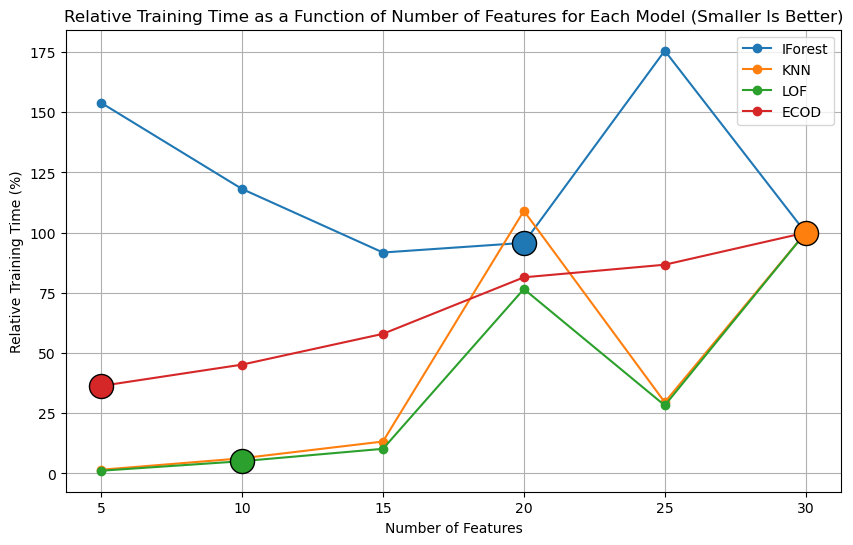

In [287]:
index = results_final_df.index
vals = results_final_df.values
results_final_df = pd.DataFrame(vals, index=pd.MultiIndex.from_tuples(index, names=['model', 'feature_set']))


df = results_final_df.reset_index()

# Add a column for the number of features
df['num_features'] = df['feature_set'].apply(lambda x: int(x.split('_')[1]))

# Calculate the relative training time with respect to top_30_features for each model
relative_times = []
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    top_30_time = model_data[model_data['feature_set'] == 'top_30_features'][1].values[0]
    relative_times.extend(model_data[1] / top_30_time)

df['relative_training_time'] = relative_times

# Plot relative training time as a function of number of features for each model
plt.figure(figsize=(10, 6))
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    line, = plt.plot(model_data['num_features'], model_data['relative_training_time']*100, label=model, marker='o')
    
    # Highlight the point with maximum Test AUC ROC
    max_auc_idx = model_data[0].idxmax()
    max_auc_point = model_data.loc[max_auc_idx]
    plt.scatter(max_auc_point['num_features'], max_auc_point['relative_training_time']*100, color=line.get_color(), s=300, edgecolors='black', zorder=5)

plt.xlabel('Number of Features')
plt.ylabel('Relative Training Time (%)')
plt.title('Relative Training Time as a Function of Number of Features for Each Model (Smaller Is Better)')
plt.legend()
plt.grid(True)
plt.show()

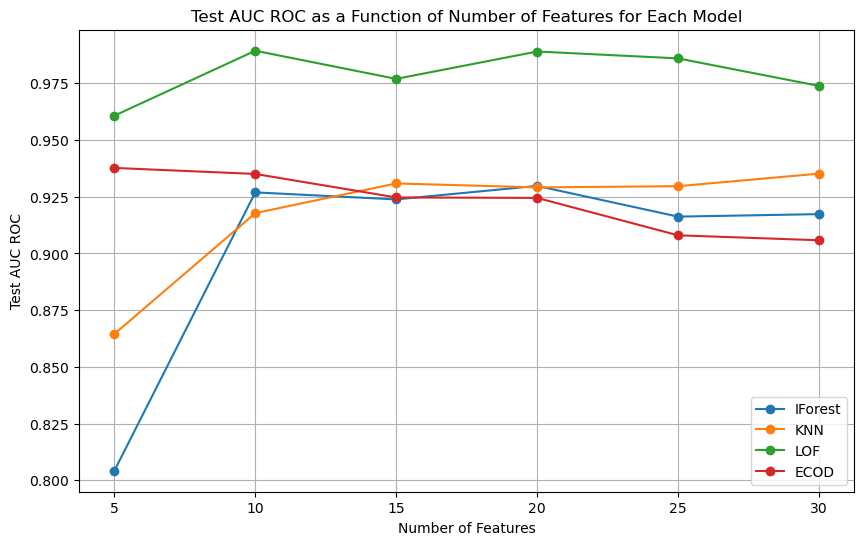

In [307]:
index = results_final_df.index
vals = results_final_df.values
results_final_df = pd.DataFrame(vals, index=pd.MultiIndex.from_tuples(index, names=['model', 'feature_set']))


df = results_final_df.reset_index()
# Add a column for the number of features
df['num_features'] = df['feature_set'].apply(lambda x: int(x.split('_')[1]))

# Plot Test AUC ROC as a function of number of features for each model
plt.figure(figsize=(10, 6))
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    line, = plt.plot(model_data['num_features'], model_data[0], label=model, marker='o')
    


plt.xlabel('Number of Features')
plt.ylabel('Test AUC ROC')
plt.title('Test AUC ROC as a Function of Number of Features for Each Model')
plt.legend()
plt.grid(True)
plt.show()

# End